# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

---

### Requirements

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !git clone https://github.com/bao18/open_earth_map.git '/content/drive/MyDrive/Remote Sensing/Assignment' # <= change path where you save code

In [3]:
# !pip install rasterio

In [4]:
# import gdown
# import zipfile

# url = "https://drive.google.com/uc?export=download&confirm=pbef&id=1SqLqv1RCJdiUFnnfIce78M9nJF_KF11U"
# output = "/content/drive/MyDrive/Remote Sensing/Assignment/OpenEathMap_Mini.zip" # <= change path where you save data
# gdown.download(url, output, quiet=False)

In [5]:
# !unzip -q "/content/drive/MyDrive/Remote Sensing/Assignment/OpenEathMap_Mini.zip" -d "/content/drive/MyDrive/Remote Sensing/Assignment/" # <= change path where you save data

### Import
---

In [1]:
import os
import time
import warnings
import numpy as np
import torch
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
import sys
# sys.path.append('/content/drive/MyDrive/Remote Sensing/Assignment/') # <= change path where you save code
import oem

warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

/home/megha/.pyenv/versions/3.8.10/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# os.environ['CUDA_VISIBLE_DEVICES']

### Define main parameters

In [3]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "../OpenEarthMap_Mini/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 30
DEVICE = "cuda"
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Prepare training and validation file lists.

In [5]:
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


In [6]:
train_fns[0]

'../OpenEarthMap_Mini/tonga/images/tonga_43.tif'

### Prepare training and validation augmentations.

In [7]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Define training and validation dataloaders

In [8]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

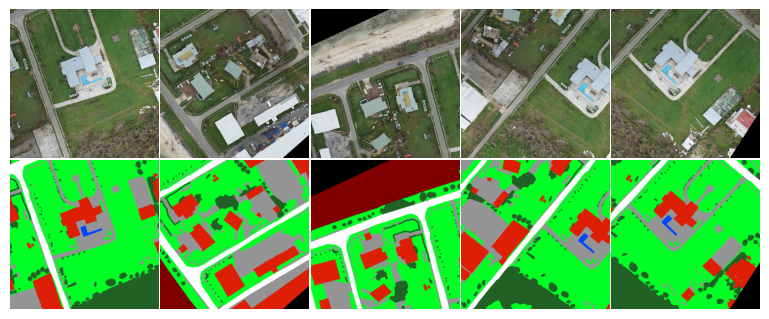

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [10]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

### Define the network architecture, optimizer, and criterion

In [15]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = [oem.losses.DiceLoss()]

### Train and validate the network

In [16]:
torch.cuda.empty_cache()

In [17]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )
    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="unet_Dice_model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.01it/s, Loss=7.52, Score=0.0603]


model saved

Epoch: 2


Valid: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s, Loss=7.42, Score=0.0728]


model saved

Epoch: 3


Valid: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s, Loss=7.11, Score=0.111]


model saved

Epoch: 4


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, Loss=6.96, Score=0.13] 


model saved

Epoch: 5


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.26it/s, Loss=6.88, Score=0.139]


model saved

Epoch: 6


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s, Loss=6.88, Score=0.14] 


model saved

Epoch: 7


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s, Loss=6.8, Score=0.15]  


model saved

Epoch: 8


Valid: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s, Loss=6.79, Score=0.151]


model saved

Epoch: 9


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, Loss=6.71, Score=0.161]


model saved

Epoch: 10


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, Loss=6.75, Score=0.157]



Epoch: 11


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.02it/s, Loss=6.71, Score=0.162]


model saved

Epoch: 12


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, Loss=6.73, Score=0.159]



Epoch: 13


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Loss=6.8, Score=0.15]  



Epoch: 14


Valid: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s, Loss=6.69, Score=0.164]


model saved

Epoch: 15


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s, Loss=6.66, Score=0.168]


model saved

Epoch: 16


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s, Loss=6.87, Score=0.141]



Epoch: 17


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s, Loss=6.7, Score=0.162] 



Epoch: 18


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s, Loss=6.76, Score=0.155]



Epoch: 19


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s, Loss=6.7, Score=0.163] 



Epoch: 20


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Loss=6.63, Score=0.171]


model saved

Epoch: 21


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, Loss=6.67, Score=0.167]



Epoch: 22


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s, Loss=6.67, Score=0.166]



Epoch: 23


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s, Loss=6.99, Score=0.127]



Epoch: 24


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s, Loss=6.69, Score=0.164]



Epoch: 25


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, Loss=6.67, Score=0.166]



Epoch: 26


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, Loss=6.64, Score=0.17] 



Epoch: 27


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, Loss=6.67, Score=0.166]



Epoch: 28


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s, Loss=6.65, Score=0.169]



Epoch: 29


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, Loss=6.61, Score=0.174]


model saved

Epoch: 30


Valid: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, Loss=6.66, Score=0.168]

Elapsed time: 13.076 min


# Testing 

### Prepare testing files

In [4]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 1068
Testing samples : 313


### Define test dataloader

In [5]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None, testing=True)

### Load trained network

In [6]:
network = oem.networks.UNetFormer(in_channels=3, n_classes=N_CLASSES, backbone_name="seresnet152d")
network = oem.utils.load_checkpoint(network, model_name="UNetFormer-seresnet152d_16_adam_Dice_mini.pth", model_dir=OUTPUT_DIR)

Loaded model:UNetFormer-seresnet152d_16_adam_Dice_mini.pth (Epoch=162, Score=0.533)


### Visualize predictions

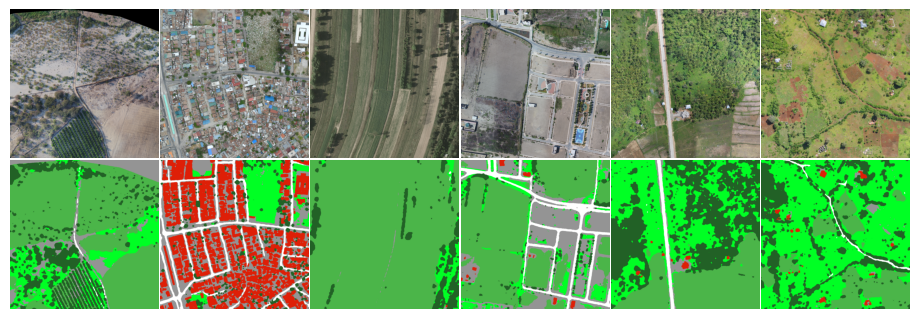

In [7]:
# visualize predictions
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

In [8]:
def get_counts(found, num_classes: int = 9):
    counts = np.zeros(num_classes)
    for k, v in found:
        counts[k] = v
    return counts

In [9]:
oem.utils.class_grey_oem_reverse

{0: 'unknown',
 1: 'Bareland',
 2: 'Grass',
 3: 'Pavement',
 4: 'Road',
 5: 'Tree',
 6: 'Water',
 7: 'Cropland',
 8: 'buildings'}

In [10]:
def get_description(percentages, grey_codes: dict = oem.utils.class_grey_oem_reverse):
    description = ""

    for i in range(len(percentages)):
        if (percentages[i] > 1):
            description += "%.1f%% %s, " % (round(percentages[i], 1), grey_codes[i])
    
    return description

In [11]:
# getting the center of the segment
def get_center(prd, mask):
    # Assume binary_mask is a 2D numpy array with dtype bool
    binary_mask = (prd == mask)
    centroid = np.median(np.argwhere(binary_mask),axis=0)
    centroid_x, centroid_y = int(centroid[1]), int(centroid[0])

    return centroid_x, centroid_y

# After trying 4 point method, we find 1 point is better indicator of location
def get_location(x,y, size = 1024, threshold = 0.1):
    center = size / 2
    offset = center * threshold

    # print(center)
    # print(offset)
    # print(x,y)

    # check if in center
    if abs(center - x) <= offset and abs(center - y) <= offset:
        return 'center'

    # print(center)
    # print(x,y)
    # check corners
    # lower left
    if x < center and y > center:
        return 'lower left'
    # lower right
    if x > center and y > center:
        return 'lower right'
    # upper left
    if x < center:
        return 'upper left'
    # upper right
    if x > center:
        return 'upper right'

6.4% Grass, 19.4% Pavement, 4.0% Road, 13.1% Tree, 48.7% Cropland, 8.4% buildings, Cropland in upper left. Pavement in lower left. 
11.9% Grass, 1.3% Pavement, 2.6% Road, 13.9% Tree, 68.0% Water, 2.4% buildings, Water in lower right. Tree in upper left. 
51.8% Grass, 11.1% Pavement, 18.9% Tree, 1.8% Cropland, 15.6% buildings, Grass in upper right. Tree in upper left. 
23.8% Grass, 30.9% Pavement, 4.5% Road, 23.1% Tree, 17.6% buildings, Pavement in lower right. Grass in upper left. 
28.3% Grass, 1.2% Road, 70.3% Tree, Tree in center. Grass in upper right. 
3.5% Grass, 60.6% Pavement, 9.3% Road, 4.5% Tree, 3.3% Water, 18.5% buildings, Pavement in lower left. buildings in upper right. 


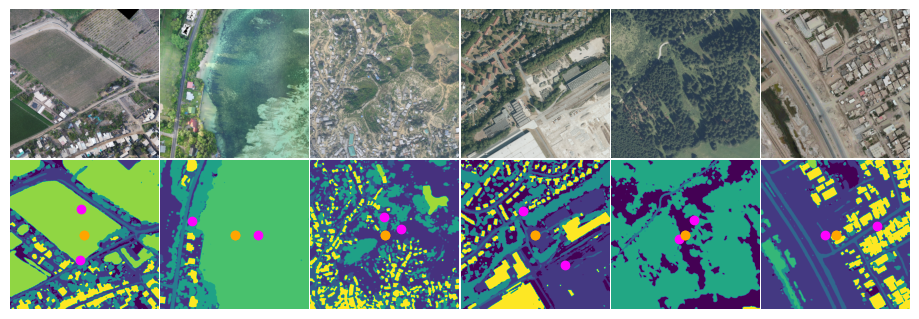

In [12]:
# visualize predictions
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

np.set_printoptions(suppress=True) 

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    newprd = np.argmax(prd.numpy(), axis=0)
    found_classes, found_counts = np.unique(newprd, return_counts=True)

    count = get_counts(zip(found_classes, found_counts))
    percentages = (count / sum(count)) * 100
    
    description = get_description(percentages)
    # print(description)

    biggest_classes = (-percentages).argsort()[:2]

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(newprd)
    for biggest_class in biggest_classes:
        center = get_center(newprd, biggest_class)
        # print(biggest_class)
        # print(center)
        location = get_location(center[0], center[1])
        desc = oem.utils.class_grey_oem_reverse[biggest_class] + ' in ' + location
        description += desc + '. '
        
        axs[1, i].plot(center[0],center[1], marker="o", markersize=6, color="magenta")
        axs[1, i].plot(1024/2, 1024/2, marker="o", markersize=6, color="orange")
        axs[1, i].axis("off")
    print(description)



In [29]:
# BLEU score

from nltk.translate.bleu_score import sentence_bleu
reference = [
    'An edge of an island filled with lush trees in the upper left. The water body stretches our in the lower right with no seeming end, and few bare land, grass, and pavements are visible as well'.split(), 
    'A rural area with crop lands covering the lower left, and a hint of forest trees in the upper right. Few buildings, pavements and roads are spread around the crop land.'.split(),
    'A cityscape of buildings with lush green trees around the center. Some pavement and grass are scattered throughout while a few roads connect the city'.split(),
    'A forest area with some crop land. The forest stretches out in the lower, while some grass is scattered near the upper right of the image'.split()
]

candidate = [
    'A peaceful body of water stretches out, with minimal bare land and grass visible. A few pavements and trees line the edge of the island'.split(),
    'An expansive field of crop lands takes up the lower left of the image, with a small cluster of trees in the upper right. Pavement, road, and a few buildings are scattered throughout the field.'.split(),
    'A bustling city with tall buildings at its center, surrounded by a sea of trees. Pavement and grass can be seen throughout the city.'.split(),
    'A dense forest with grassy patches scattered in the upper right. A small area of crop lands can be seen near the edge of the forest in the lower left.'.split(),
]

score1 = 0
score2 = 0
score3 = 0
score4 = 0
score = 0

for c in candidate:
    score += sentence_bleu(reference, c)
    score1 += sentence_bleu(reference, c, weights=(1, 0, 0, 0))
    score2 += sentence_bleu(reference, c, weights=(0, 1, 0, 0))
    score3 += sentence_bleu(reference, c, weights=(0, 0, 1, 0))
    score4 += sentence_bleu(reference, c, weights=(0, 0, 0, 1))

print(score1 / len(candidate))
print(score2 / len(candidate))
print(score3 / len(candidate))
print(score4 / len(candidate))
print(score / len(candidate))

0.5660409857189461
0.20352534476915946
0.05452754796838312
0.02371287864963749
0.08660804966578317


## Testing with RSICD

In [12]:
# !pip install tqdm==4.63.1

In [31]:
from datasets import load_dataset

rsicd_dataset = load_dataset("arampacha/rsicd", split="train")

Using custom data configuration arampacha--rsicd-56e24d6cc63cb9d9
Found cached dataset parquet (/home/megha/.cache/huggingface/datasets/arampacha___parquet/arampacha--rsicd-56e24d6cc63cb9d9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [146]:
rsicd_captions = []
rsicd_images = []

In [123]:
[500, 1700, 1800, 1900, 2000, 2600, 2900, 3000, 3600, 6600]

[500, 1700, 1800, 1900, 2000, 2600, 2900, 3000, 3600, 6600]

In [174]:
rsicd_dataset[6600]

{'filename': 'rsicd_images/sparseresidential_104.jpg',
 'captions': ['a big square house and a little square house in it .',
  'two houses with dark gray roof in the middle .',
  'two houses in the middle while surrounded by so many dark green plants .',
  'a residential with two houses and many plants while a light brown road in side .',
  'a building is surrounded by many green trees .'],
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>}

In [175]:
rsicd_captions.append(rsicd_dataset[6600]['captions'][4])
rsicd_images.append(rsicd_dataset[6600]['image'])

In [176]:
rsicd_captions

['the bare earth has grown a small amount of vegetation.',
 'many buildings and green trees are in a business area .',
 'many commercial tall buildings are in a commercial area .',
 'some buildings and green trees are in a commercial area .',
 'many buildings and many green trees are in a dense residential area .',
 'many pieces of agricultural land are together.',
 'many green trees are in a piece of forest .',
 'a bare land in the middle of the forest.',
 'some buildings and many green trees are located in an average residential area.',
 'a building is surrounded by many green trees .']

In [180]:
import math
from oem import transforms
from PIL import Image

def get_rsicd_data(idx, n_classes = 9):
    img = rsicd_images[idx]
    msk = Image.fromarray(np.zeros(img.size[:2], dtype="uint8"))
    classes = np.arange(n_classes).tolist()
    to_tensor = transforms.ToTensor(classes=classes)

    h, w = msk.size
    power_h = math.ceil(np.log2(h) / np.log2(2))
    power_w = math.ceil(np.log2(w) / np.log2(2))
    if 2**power_h != h or 2**power_w != w:
        img = img.resize((2**power_w, 2**power_h), resample=Image.BICUBIC)
        msk = msk.resize((2**power_w, 2**power_h), resample=Image.NEAREST)
        data = {"image": img, "mask": msk}

    data = to_tensor(
        {
            "image": np.array(data["image"], dtype="uint8"),
            "mask": np.array(data["mask"], dtype="uint8"),
        }
    )
    return data["image"], data["mask"]

94.5% Bareland, 2.1% Pavement, 2.7% Tree, Bareland in center. Tree in upper right. 
3.9% Grass, 24.7% Pavement, 3.6% Road, 17.5% Tree, 50.2% buildings, buildings in lower right. Pavement in center. 
14.1% Pavement, 27.2% Tree, 58.4% buildings, buildings in center. Tree in upper right. 
9.8% Grass, 39.4% Pavement, 9.0% Road, 4.5% Tree, 3.7% Cropland, 33.6% buildings, Pavement in center. buildings in center. 
17.3% Grass, 4.6% Pavement, 7.7% Road, 39.3% Tree, 31.1% buildings, Tree in upper right. buildings in center. 
13.5% Grass, 43.8% Cropland, 41.2% buildings, Cropland in upper left. buildings in upper right. 
95.8% Grass, 3.9% Tree, Grass in center. Tree in lower left. 
13.3% Grass, 86.7% Tree, Tree in upper left. Grass in lower right. 
49.8% Grass, 10.1% Pavement, 7.6% Road, 16.3% Tree, 5.7% Cropland, 10.5% buildings, Grass in center. Tree in upper left. 
16.2% Grass, 1.6% Road, 78.8% Tree, 3.3% buildings, Tree in upper left. Grass in lower right. 


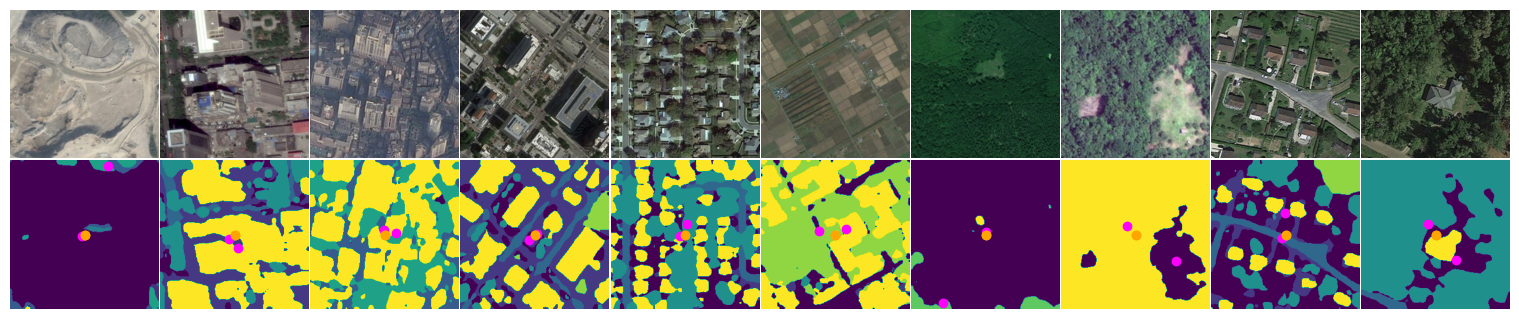

In [182]:
# visualize predictions
NPLOT = len(rsicd_captions)
idxs = range(len(rsicd_captions))

np.set_printoptions(suppress=True) 

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = get_rsicd_data(idx)

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    newprd = np.argmax(prd.numpy(), axis=0)
    found_classes, found_counts = np.unique(newprd, return_counts=True)

    count = get_counts(zip(found_classes, found_counts))
    percentages = (count / sum(count)) * 100
    
    description = get_description(percentages)
    # print(description)

    biggest_classes = (-percentages).argsort()[:2]

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(newprd)
    for biggest_class in biggest_classes:
        center = get_center(newprd, biggest_class)
        # print(biggest_class)
        # print(center)
        location = get_location(center[0], center[1], size=len(newprd))
        desc = oem.utils.class_grey_oem_reverse[biggest_class] + ' in ' + location
        description += desc + '. '
        
        axs[1, i].plot(center[0],center[1], marker="o", markersize=6, color="magenta")
        axs[1, i].plot(len(newprd)/2, len(newprd)/2, marker="o", markersize=6, color="orange")
        axs[1, i].axis("off")
    print(description)



In [185]:
# BLEU score

from nltk.translate.bleu_score import sentence_bleu
reference = [
    'the bare earth has grown a small amount of vegetation.'.split(),
 'many buildings and green trees are in a business area .'.split(),
 'many commercial tall buildings are in a commercial area .'.split(),
 'some buildings and green trees are in a commercial area .'.split(),
 'many buildings and many green trees are in a dense residential area .'.split(),
 'many pieces of agricultural land are together.'.split(),
 'many green trees are in a piece of forest .'.split(),
 'a bare land in the middle of the forest.'.split(),
 'some buildings and many green trees are located in an average residential area.'.split(),
 'a building is surrounded by many green trees .'.split()
    
]

candidate = [
    'a city with many tall buildings and a few trees'.split(), # 3rd
    'a busy city with lots of pavement and buildings'.split(), # 4th
    'a city with many buildings and trees'.split(), # 5th
    'a grassy field with a few trees'.split(), # 7th
    'a forest with a small patch of grass'.split(), # 8th
]

score1 = 0
score2 = 0
score3 = 0
score4 = 0
score = 0

for c in candidate:
    score += sentence_bleu(reference, c)
    score1 += sentence_bleu(reference, c, weights=(1, 0, 0, 0))
    score2 += sentence_bleu(reference, c, weights=(0, 1, 0, 0))
    score3 += sentence_bleu(reference, c, weights=(0, 0, 1, 0))
    score4 += sentence_bleu(reference, c, weights=(0, 0, 0, 1))

print(score1 / len(candidate))
print(score2 / len(candidate))
print(score3 / len(candidate))
print(score4 / len(candidate))
print(score / len(candidate))

0.5088888888888888
0.13968253968253969
0.04
2.2250738585072626e-308
1.141067352621631e-78


In [19]:
np.zeros(9)

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Save predictions in png files

In [20]:
import math
from PIL import Image

PR_DIR = "/content/drive/My Drive/Colab/OEM/png" # <= change path where you save predictions
os.makedirs(PR_DIR, exist_ok=True)

save_fns = []

network.eval().to(DEVICE)
for test_fn in test_fns:
    img = Image.fromarray(oem.dataset.load_multiband(test_fn))

    w, h = img.size[:2]
    power_h = math.ceil(np.log2(h) / np.log2(2))
    power_w = math.ceil(np.log2(w) / np.log2(2))
    if 2**power_h != h or 2**power_w != w:
      img = img.resize((2**power_w, 2**power_h), resample=Image.BICUBIC)
    img = np.array(img)

    # test time augmentation
    imgs = []
    imgs.append(img.copy())
    imgs.append(img[:, ::-1, :].copy())
    imgs.append(img[::-1, :, :].copy())
    imgs.append(img[::-1, ::-1, :].copy())

    input = torch.cat([torchvision.transforms.functional.to_tensor(x).unsqueeze(0) for x in imgs], dim=0).float().to(DEVICE)

    pred = []
    with torch.no_grad():
      msk = network(input) 
      msk = torch.softmax(msk[:, :, ...], dim=1)
      msk = msk.cpu().numpy()
      pred = (msk[0, :, :, :] + msk[1, :, :, ::-1] + msk[2, :, ::-1, :] + msk[3, :, ::-1, ::-1])/4

    pred = Image.fromarray(pred.argmax(axis=0).astype("uint8"))
    y_pr = pred.resize((w, h), resample=Image.NEAREST)

    filename = os.path.basename(test_fn).replace('tif','png')
    save_fn = os.path.join(PR_DIR, filename)
    y_pr.save(save_fn)
    save_fns.append(save_fn)

PermissionError: [Errno 13] Permission denied: '/content'